## <b> Introduction to time series smoothing
    
Time series data is composed of signals and noise, where signals capture intrinsic dynamics of the process; however, noise represents the unmodeled component of a signal. The intrinsic dynamics of a time series signal can be as simple as the mean of the process or it can be a complex functional form within observations.

- The smoothing forecasting methods can be considered as filters that take inputs and separate the trend and noise components.

The efficacy of the extraction of estimated trend and noise depends on other parameters related to time series signal composition such as the presence of trend, seasonality, and residual (noise). To handle each of these components of time series, different treatments are required. This chapter will cover multiple approaches to smooth to handle different components of the time series signal. Let's start with an example

In [1]:
# Import modules
import requests
import statsmodels.api as sm
import io
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# Load Dataset
DATA_URL="http://robjhyndman.com/tsdldata/data/nybirths.dat"
fopen = requests.get(DATA_URL).content
ds=pd.read_csv(
    io.StringIO(fopen.decode('utf-8')),
    header=None, names=['birthcount']
)
ds.head(5)

,birthcount
0,26.663
1,23.598
2,26.931
3,24.740
4,25.806


In [3]:
# Add time index
date = pd.date_range("1946-01-01", "1959-12-31", freq="1M")
ds['Date']=pd.DataFrame(date)
ds.set_index('Date', inplace=True, drop=True)
ds.head(5)

,birthcount
Date,
1946-01-31,26.663
1946-02-28,23.598
1946-03-31,26.931
1946-04-30,24.740
1946-05-31,25.806


The seasonal_decompose function from the stats models module is utilized to decompose the time series signal into trend, seasonality, and residual components. The decomposition can be additive or multiplicative as discussed in Chapter 2.

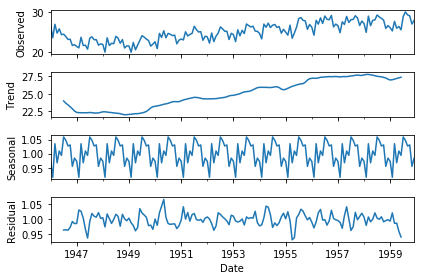

In [4]:
# decompose dataset
res = sm.tsa.seasonal_decompose(ds.birthcount, model="multiplicative")
resplot = res.plot()

The preceding time series signal is composed of trend, seasonality, and residual (noise). The smoothing helps remove the residual component, for smoothing process, and captures the trend and seasonality components for the forecasting signal.The first step model to include mean, trend, and non-seasonal patterns is to extrapolate it using smoothing. The moving average smoothing evaluates expectations E(xt) using all previous observations.


The smoothing methods are based on the assumption that time series data is locally stationary with small variations in the mean. Thus, we can use the mean at time t to predict at t+1 where time delta is small enough to keep the signal stationary. The major limitation with these moving average-based methods is that it treats all n samples used in smoothing equally and ignores the observation recency effect, that is, giving higher weights to recent observations. Weighted moving average can be used to weight recent observation realtively higher but places another challenge for the evaluation of weights.

The limitation from moving average and weighted moving average is addressed by exponential smoothing by application of exponential decaying weights on observations.

### <b> First Order exponential Smoothing
As the window size for moving average increases, the weights assigned to each observation become smaller. The first order exponential extends this current approach by providing exponential to historical data points where weights decrease exponentially from the most recent data point to the oldest. The first order exponential smoothing can be defined as follows:

\begin{align}
x_{t+1} & = α(x_t) + α(1-α)(x_{t-1}) + α(1-α)^2(x_{t-2}) + ...\\
\end{align}

- α is the smoothing factor between [0,1] and controls the rate at which weights decrease and xt is the observed value at time t. The higher value of α leads to a faster decay of weights; thus, historical data will have less impact on the forecasted value.

In [5]:
# Load Dataset
ibm_df = pd.read_csv(
    '../Data Files/ibm-common-stock-closing-prices.csv'
)
ibm_df.head(5)

,Date,IBM common stock closing prices
0,1962-01-02,572.00
1,1962-01-03,577.00
2,1962-01-04,571.25
3,1962-01-05,560.00
4,1962-01-08,549.50


In [6]:
# Rename the second column
ibm_df.rename(columns={
    'IBM common stock closing prices': 'Close_Price'
},inplace=True)
ibm_df.head(5)

,Date,Close_Price
0,1962-01-02,572.00
1,1962-01-03,577.00
2,1962-01-04,571.25
3,1962-01-05,560.00
4,1962-01-08,549.50


In [7]:
# Function for Sigle exponential smoothing
def single_exp_smoothing(x, alpha):
    F = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        F.append(alpha * x[t] + (1 - alpha) * F[t-1])
    return F

ibm_df['SES'] = single_exp_smoothing(ibm_df['Close_Price'], 0.8)
ibm_df.head(5)

,Date,Close_Price,SES
0,1962-01-02,572.00,572.000
1,1962-01-03,577.00,576.000
2,1962-01-04,571.25,572.200
3,1962-01-05,560.00,562.440
4,1962-01-08,549.50,552.088


Text(0.5,1,'Single Exponential Smoothing')

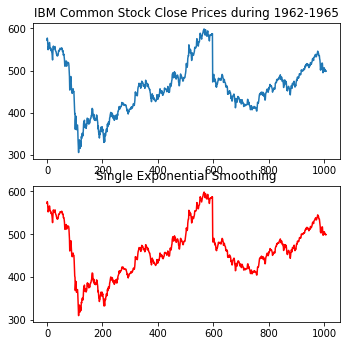

In [8]:
# Plot Single Exponential Smoothing forecasted value
fig = plt.figure(figsize=(5.5, 5.5))
ax = fig.add_subplot(2,1,1)
ibm_df['Close_Price'].plot(ax=ax)
ax.set_title('IBM Common Stock Close Prices during 1962-1965')

ax = fig.add_subplot(2,1,2)
ibm_df['SES'].plot(ax=ax, color='r')
ax.set_title('Single Exponential Smoothing')

Text(0.5,1,'Alpha 1.0')

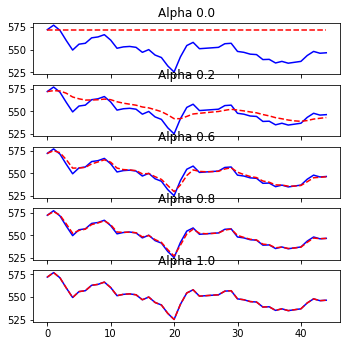

In [9]:
# Plot the forecasted values using multiple alpha values
# Calculate the moving averages using 'rolling' and 'mean' functions
ibm_df['SES0'] = single_exp_smoothing(ibm_df['Close_Price'], 0)
ibm_df['SES2'] = single_exp_smoothing(ibm_df['Close_Price'], 0.2)
ibm_df['SES6'] = single_exp_smoothing(ibm_df['Close_Price'], 0.6)
ibm_df['SES8'] = single_exp_smoothing(ibm_df['Close_Price'], 0.8)
ibm_df['SES10'] = single_exp_smoothing(ibm_df['Close_Price'], 1)

# Plot the curves
f, axarr = plt.subplots(5, sharex=True)
f.set_size_inches(5.5, 5.5)

ibm_df['Close_Price'][:45].plot(color='b', linestyle = '-', ax=axarr[0])
ibm_df['SES0'][:45].plot(color='r', linestyle = '--', ax=axarr[0])
axarr[0].set_title('Alpha 0.0')

ibm_df['Close_Price'][:45].plot(color='b', linestyle = '-', ax=axarr[1])
ibm_df['SES2'][:45].plot(color='r', linestyle = '--', ax=axarr[1])
axarr[1].set_title('Alpha 0.2')

ibm_df['Close_Price'][:45].plot(color='b', linestyle = '-', ax=axarr[2])
ibm_df['SES6'][:45].plot(color='r', linestyle = '--', ax=axarr[2])
axarr[2].set_title('Alpha 0.6')

ibm_df['Close_Price'][:45].plot(color='b', linestyle = '-', ax=axarr[3])
ibm_df['SES8'][:45].plot(color='r', linestyle = '--', ax=axarr[3])
axarr[3].set_title('Alpha 0.8')

ibm_df['Close_Price'][:45].plot(color='b', linestyle = '-', ax=axarr[4])
ibm_df['SES10'][:45].plot(color='r', linestyle = '--', ax=axarr[4])
axarr[4].set_title('Alpha 1.0')

- The preceding figure illustrates that, at α = 0, the forecasted value is a constant, and for α = 1, the forecasted series shifts by 1 time lag.

- The preceding figure illustrates that alpha has a huge impact on forecasting; thus, getting the right alpha value is critical while setting up forecasting. As the smoothing helps to reduce the dataset variance, it will reduce the variance of forecasted series between zero to actual variance of dataset. 